# Preprocessing Data

In [1]:
# import package
import math
import sys
import numpy as np
import pandas as pd

In [2]:
# load dataset
datasets = {
    'spinach' : '../datasets/spinach_datasets_27apr22.csv',
    'caisim' : '../datasets/caisim_datasets.csv'
}

raw_data = {}
for plant_name, path in datasets.items():
    raw_data[plant_name] = pd.read_csv(path)

In [3]:
# preprocessing
# set label bayam merah
# 4 - 2 - 1 - 3 - 5 ( Optimal - Non Optimal)

# set label caisim
# 1 - 2 - 4 -5 - 3 ( Optimal - Non Optimal)
optimal_list = {
    'spinach' : ['Spinach 4',
                'Spinach 2',
               'Spinach 1',
              ],
    'caisim' : ['Caisim 1',
                'Caisim 2',
                'Caisim 4',]
}

not_optimal_list = {
    'spinach' : ['Spinach 3',
               'Spinach 5'],
    'caisim' : ['Caisim 5',
                'Caisim 3']
}


pre_processing_data = {}

for plant_name, path in datasets.items():
    list_pd = []
    for index, row in raw_data[plant_name].iterrows():

        # skip if value is blanks in temperature, humidity, light-intensity, soil-mosuter
        if pd.isna(row['temperature']) or pd.isna(row['humidity']) or pd.isna(row['light_intensity']) or pd.isna(row['soil_moisture']):
            continue

        # change soil moisture to 0 : Low, 50 : Normwl, 100 : High
        if row['name'] in optimal_list[plant_name]:
            # change status to optimal,

            # modify status if low to normal or high, as its not possible to high
            if row['soil_moisture'] == 'Low':
                row['soil_moisture'] = 'Normal'

            row['STATUS'] = 'Optimal'

        elif row['name'] in not_optimal_list[plant_name]:
            # change status to not optimal_list
            row['soil_moisture'] = 'Low' # change soil_moisture to Low
            row['STATUS'] = 'Not Optimal'

        # add new column for numerical features in knn instead of categorical features
        if row['soil_moisture'] == 'Low':
            row['soil_moisture_encode'] = 0

        if row['soil_moisture'] == 'Normal':
            row['soil_moisture_encode'] = 50

        if row['soil_moisture'] == 'High':
            row['soil_moisture_encode'] = 100

        list_pd.append(row)
    pre_processing_data[plant_name] = pd.DataFrame(list_pd)


In [4]:
# save to excel format
preprocessing_save_path = {
    'spinach' : '../datasets/spinach_datasets_preprocessing_27apr22.xlsx',
    'caisim' : '../datasets/caisim_datasets_preprocessing.xlsx'
}

for plant_name, saved_path in preprocessing_save_path.items():
    # save prerpocessing result as excel
    pre_processing_data[plant_name].to_excel(saved_path, header=True, index=False)

# Training and Testing KNN Model

just run this step, skip preprocessing step and load from existing preprocesing file

In [5]:
# import library
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [6]:
# load from preprocessing files
preprocessing_save_path = {
    'spinach' : '../datasets/spinach_datasets_preprocessing_27apr22.xlsx',
    'caisim' : '../datasets/caisim_datasets_preprocessing.xlsx'
}
pre_processing_data = {}

for plant_name, saved_path in preprocessing_save_path.items():
    # save prerpocessing result as excel
    pre_processing_data[plant_name] = pd.read_excel(saved_path)

In [7]:
# prepare training and testing data

training_features_column = ['temperature', 'humidity', 'light_intensity', 'soil_moisture_encode']
target_column = ['STATUS']
list_plant_name = ['spinach', 'caisim']
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for plant_name in list_plant_name:
    # Split dataset into training set and test set
    X_train[plant_name], X_test[plant_name], y_train[plant_name], y_test[plant_name] = train_test_split(pre_processing_data[plant_name][training_features_column], pre_processing_data[plant_name][target_column], test_size=0.3)

#pre_processing_data['bayam'][training_features_column]

In [8]:
saved_model_path = {
    'spinach' : '../trained/spinach_knn_model_27apr22.sav',
    'caisim' : '../trained/caisim_knn_model.sav'
}

#Train the model using the training sets
for plant_name in list_plant_name:
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # train model
    knn.fit(X_train[plant_name], np.ravel(y_train[plant_name]))

    #Predict the response for test dataset
    y_pred = knn.predict(X_test[plant_name])

    # Model Accuracy, how often is the classifier correct?'
    clf_report = classification_report(y_test[plant_name], y_pred, target_names=["Optimal", "Not Optimal"])
    accuracy = metrics.accuracy_score(y_test[plant_name], y_pred) * 100

    print(f"KNN Performance Report for {plant_name} models: ")
    print(f"Accuracy : {accuracy:.2f} %")
    print(f"Classification Report : {clf_report}")

    # save the model
    pickle.dump(knn, open(saved_model_path[plant_name].format(accuracy), 'wb'))

KNN Performance Report for spinach models: 
Accuracy : 100.00 %
Classification Report :               precision    recall  f1-score   support

     Optimal       1.00      1.00      1.00      6323
 Not Optimal       1.00      1.00      1.00      9404

    accuracy                           1.00     15727
   macro avg       1.00      1.00      1.00     15727
weighted avg       1.00      1.00      1.00     15727

KNN Performance Report for caisim models: 
Accuracy : 99.37 %
Classification Report :               precision    recall  f1-score   support

     Optimal       1.00      0.99      0.99      1638
 Not Optimal       0.99      1.00      0.99      2472

    accuracy                           0.99      4110
   macro avg       0.99      0.99      0.99      4110
weighted avg       0.99      0.99      0.99      4110



# Summary and Analysis

## Dataset Visualization

No handles with labels found to put in legend.


Bayam Preprocessing Dataframe Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52422 entries, 0 to 52421
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    52422 non-null  int64  
 1   name                  52422 non-null  object 
 2   temperature           52422 non-null  float64
 3   humidity              52422 non-null  float64
 4   light_intensity       52422 non-null  float64
 5   soil_moisture         52422 non-null  object 
 6   STATUS                52422 non-null  object 
 7   time                  52422 non-null  object 
 8   soil_moisture_encode  52422 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.6+ MB
None

          id       name  temperature  humidity  light_intensity soil_moisture  \
0          1  Spinach 1         28.9      88.5             0.00          High   
1          2  Spinach 2         28.9      88.5             

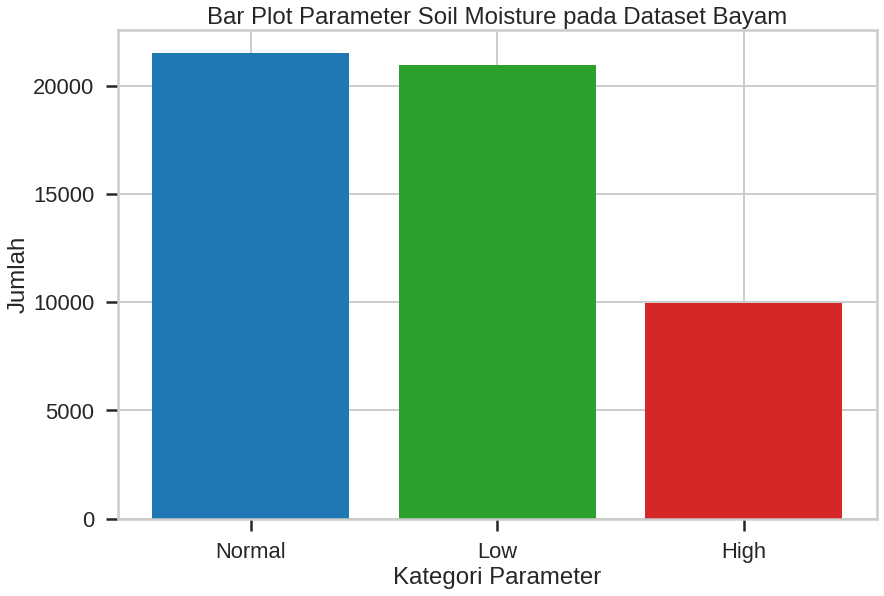

No handles with labels found to put in legend.



Bar Plot Status
Optimal        31452
Not Optimal    20970
Name: STATUS, dtype: int64


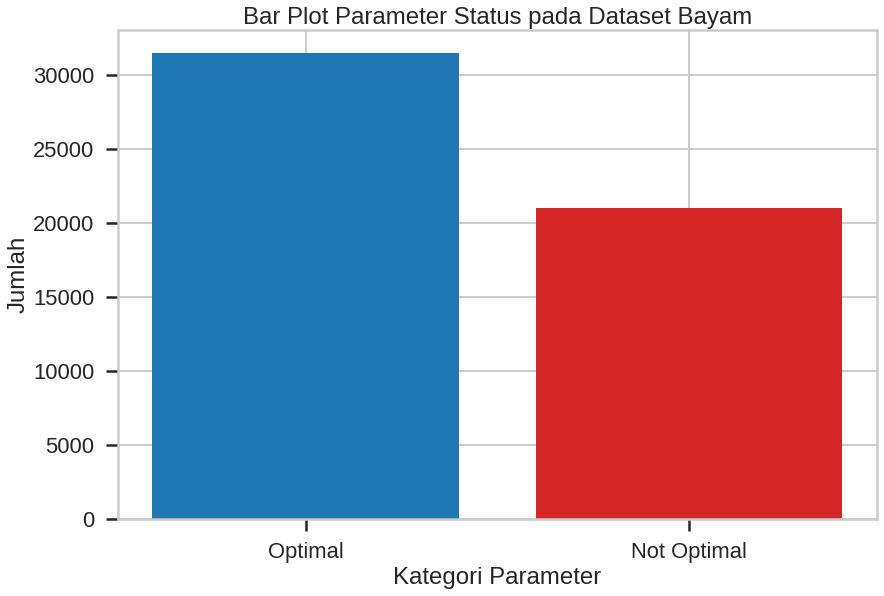

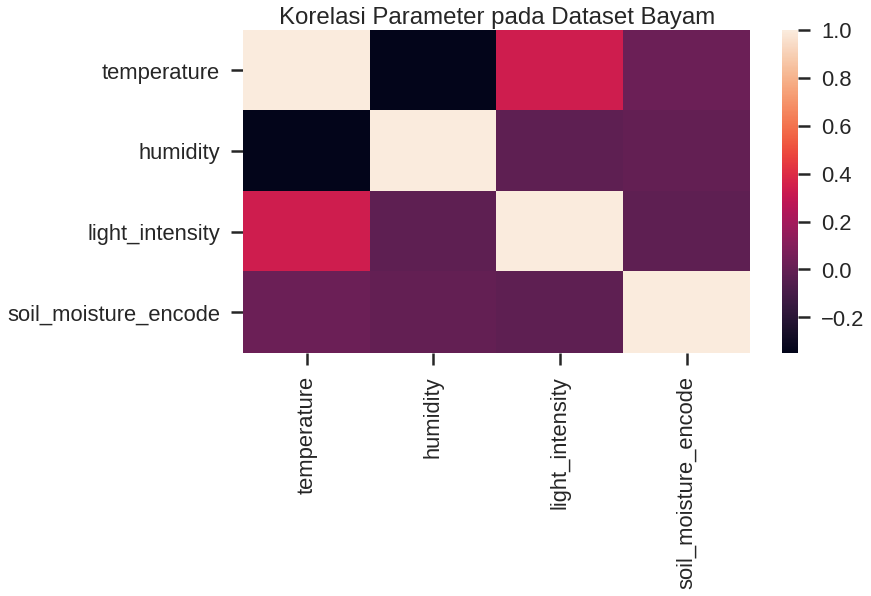

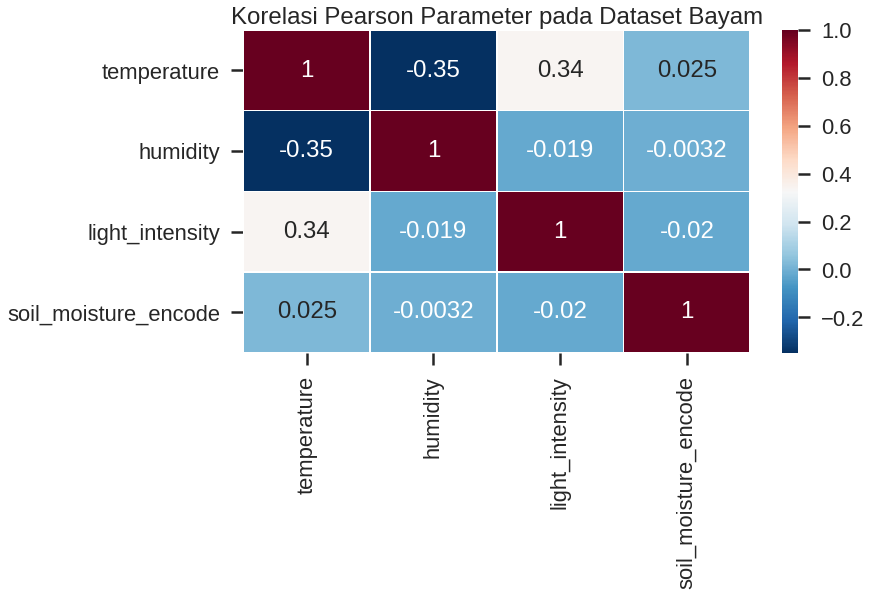

No handles with labels found to put in legend.


Caisim Preprocessing Dataframe Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13700 entries, 0 to 13699
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    13700 non-null  int64  
 1   name                  13700 non-null  object 
 2   temperature           13700 non-null  float64
 3   humidity              13700 non-null  float64
 4   light_intensity       13700 non-null  float64
 5   soil_moisture         13700 non-null  object 
 6   STATUS                13700 non-null  object 
 7   time                  13700 non-null  object 
 8   soil_moisture_encode  13700 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 963.4+ KB
None

          id      name  temperature  humidity  light_intensity soil_moisture  \
0          1  Caisim 1         33.8      52.1          13945.4          High   
1          2  Caisim 2         33.8      52.1          139

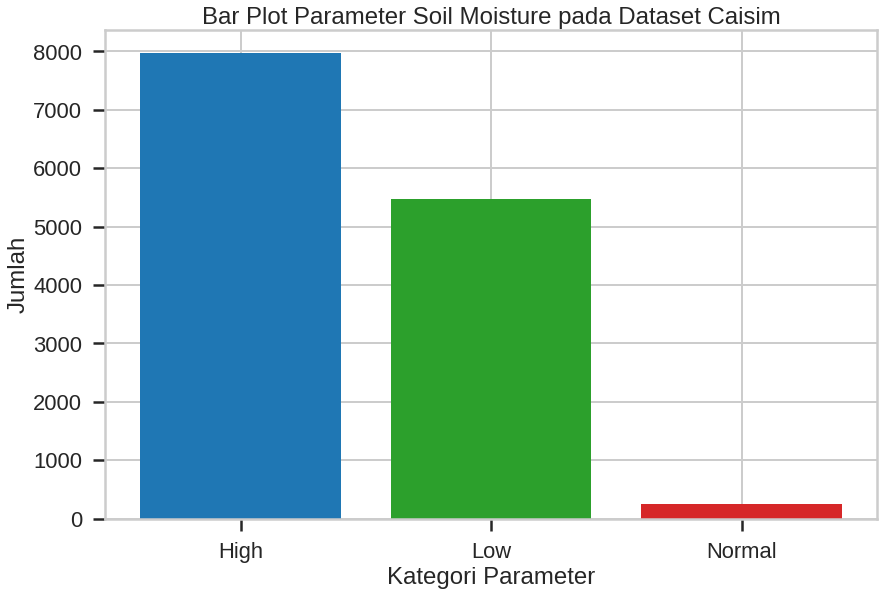

No handles with labels found to put in legend.



Bar Plot Status
Optimal        8220
Not Optimal    5480
Name: STATUS, dtype: int64


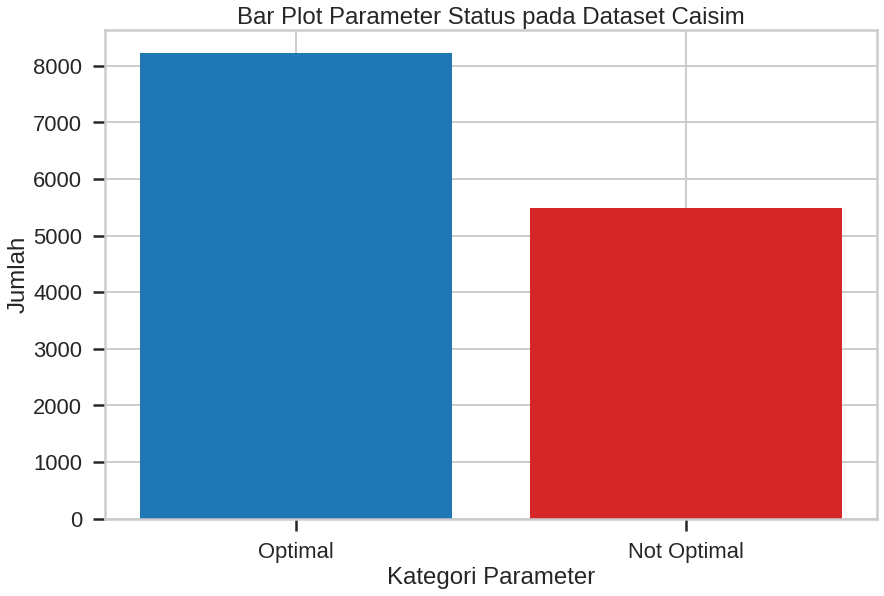

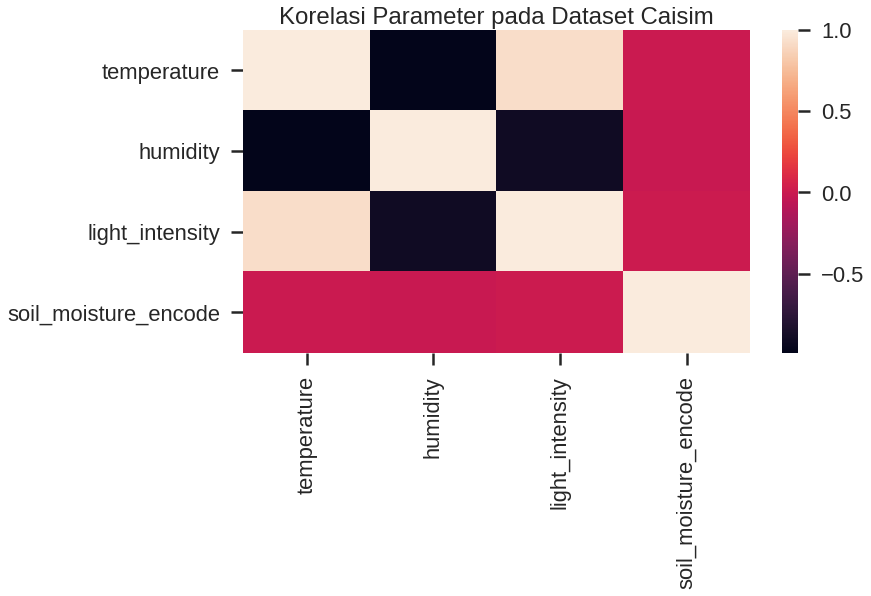

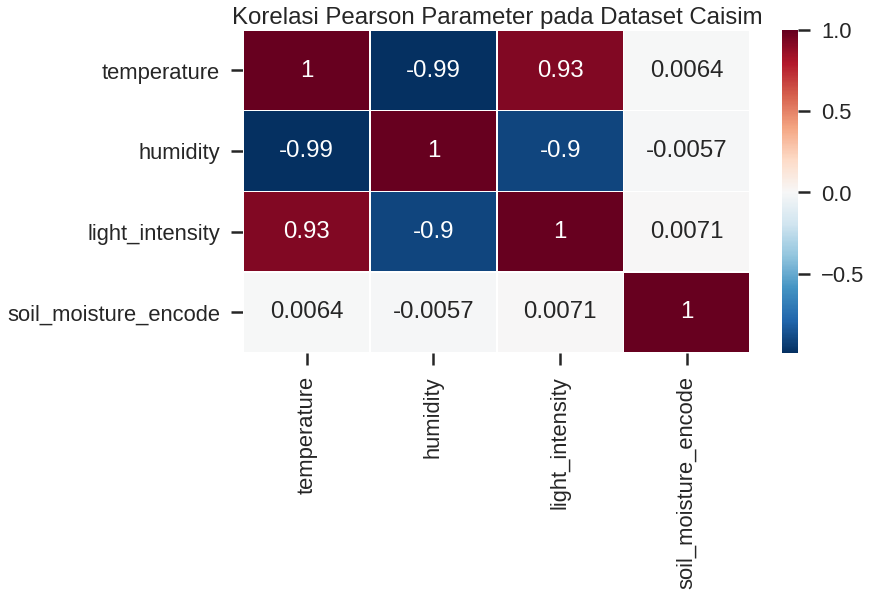

In [6]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.style as style

%matplotlib inline
style.use('seaborn-poster') #sets the size of the charts
style.use('seaborn-whitegrid')
sns.set_context('poster')
## Dataset Analysis
preprocessing_save_path = {
    'bayam' : '../datasets/spinach_datasets_preprocessing_27apr22.xlsx',
    'caisim' : '../datasets/caisim_datasets_preprocessing.xlsx'
}
pre_processing_data = {}

for plant_name, saved_path in preprocessing_save_path.items():
    # save prerpocessing result as excel
    print(f"\n{'='*100}") # space
    pre_processing_data[plant_name] = pd.read_excel(saved_path)
    print(f"{plant_name.title()} Preprocessing Dataframe Information")
    print(pre_processing_data[plant_name].info()) # show info

    # show data
    print(f"\n{'='*100}") # space
    print(pre_processing_data[plant_name]) # show data

    # bar plot moisture
    df_unique_moist = pre_processing_data[plant_name].soil_moisture.value_counts()
    print(f"\n{'='*100}") # space
    print("Bar Plot Moisture")
    print(df_unique_moist)

    fig, ax = plt.subplots()
    ax.bar(df_unique_moist.index,df_unique_moist, color=['tab:blue','tab:green','tab:red'])
    ax.set_title('Bar Plot Parameter Soil Moisture pada Dataset {}'.format(plant_name.title()))
    ax.set_xlabel('Kategori Parameter')
    ax.set_ylabel('Jumlah')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('images/{}_{}.png'.format("bar_plot_soil_moisture",plant_name), dpi=100)
    plt.show()

    # bar plot status
    df_unique_status = pre_processing_data[plant_name].STATUS.value_counts()


    print(f"\n{'='*100}") # space
    print("Bar Plot Status")
    print(df_unique_status)
    fig, ax = plt.subplots()
    ax.bar(df_unique_status.index,df_unique_status, color=['tab:blue','tab:red'])
    ax.set_title('Bar Plot Parameter Status pada Dataset {}'.format(plant_name.title()))
    ax.set_xlabel('Kategori Parameter')
    ax.set_ylabel('Jumlah')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('images/{}_{}.png'.format("bar_plot_status",plant_name), dpi=100)
    plt.show()

    # correlations
    correlations = pre_processing_data[plant_name].loc[:, pre_processing_data[plant_name].columns!="id"].corr()
    fig, ax = plt.subplots()
    ax.set_title('Korelasi Parameter pada Dataset {}'.format(plant_name.title()))
    sns.heatmap(correlations)
    plt.tight_layout()
    plt.savefig('images/{}_{}.png'.format("heatmaps_plot_correlations",plant_name), dpi=100)
    plt.show()


    # pearson correlation
    pearson_corr = pre_processing_data[plant_name].loc[:, pre_processing_data[plant_name].columns!="id"].corr(method='pearson')
    fig, ax = plt.subplots()
    ax.set_title('Korelasi Pearson Parameter pada Dataset {}'.format(plant_name.title()))
    sns.heatmap(pearson_corr,
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
    plt.tight_layout()
    plt.savefig('images/{}_{}.png'.format("heatmaps_plot_pearson_correlations",plant_name), dpi=100)
    plt.show()

## Model Performance Analysis

<Figure size 921.6x633.6 with 0 Axes>

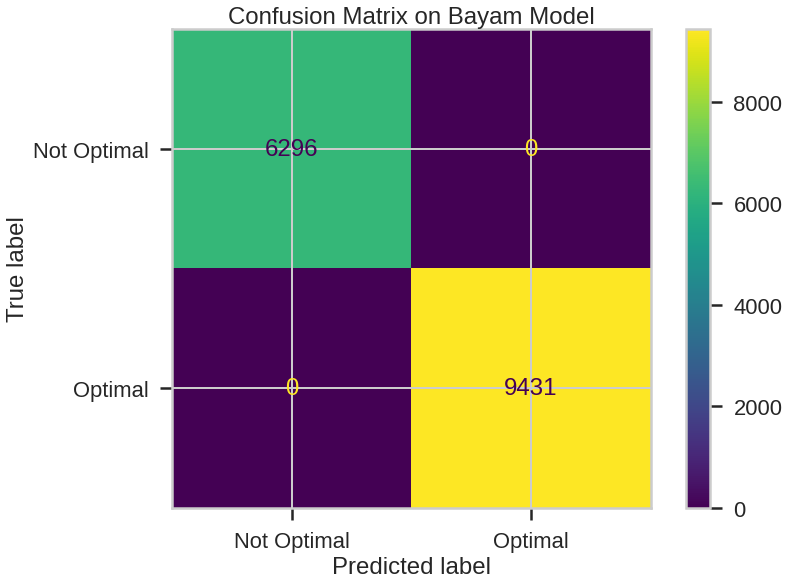

<Figure size 921.6x633.6 with 0 Axes>

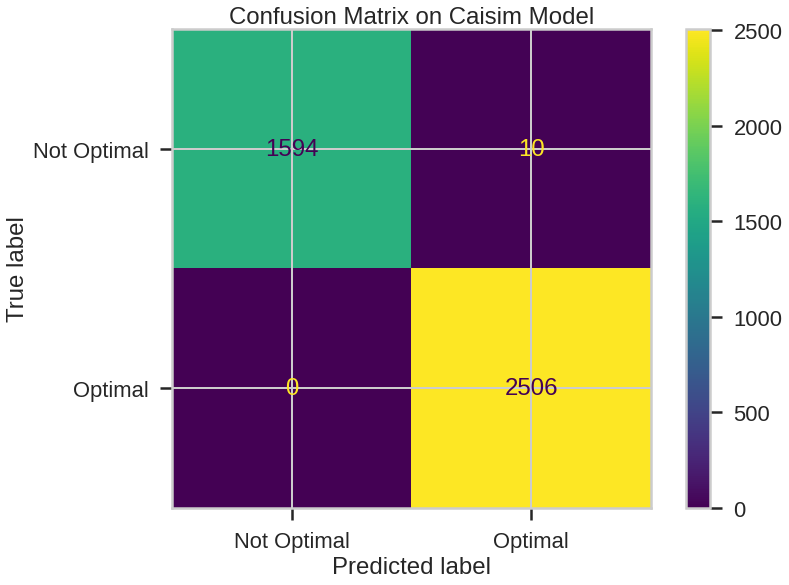

In [12]:
from sklearn import tree
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model analysis
saved_model_path = {
    'bayam' : '../trained/spinach_knn_model_27apr22.sav',
    'caisim' : '../trained/caisim_knn_model.sav'
}

# prepare training and testing data
training_features_column = ['temperature', 'humidity', 'light_intensity', 'soil_moisture_encode']
target_column = ['STATUS']
list_plant_name = ['bayam', 'caisim']
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for plant_name in list_plant_name:
    # Split dataset into training set and test set
    X_train[plant_name], X_test[plant_name], y_train[plant_name], y_test[plant_name] = train_test_split(
        pre_processing_data[plant_name][training_features_column], pre_processing_data[plant_name][target_column],
        test_size=0.3)

# load model
loaded_model_list = []
for plant_name, saved_path in saved_model_path.items():
    trained_model = pickle.load(open(saved_path, 'rb'))

    #Predict the response for test dataset
    y_pred = trained_model.predict(X_test[plant_name])
    cm = confusion_matrix(y_test[plant_name], y_pred,  labels=trained_model.classes_)
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=trained_model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix on {plant_name.title()} Model")
    plt.savefig('images/{}_{}.png'.format("confusion_matrix",plant_name), dpi=100)
    plt.show()